In [6]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib.pyplot as plt
import mplhep as hep
import vector as vec

import matplotlib as mpl

plt.style.use(hep.style.CMS)
# %matplotlib inline

In [7]:
filenameSGN = '/eos/user/a/aperego/tagger/tree_Zjj_10k.root'
fileSGN = uproot.open(filenameSGN)

filenameBKG = '/eos/user/a/aperego/tagger/tree_DY_10k.root'
fileBKG = uproot.open(filenameBKG)

In [8]:
fileBKG.keys()

['GenParticles;3', 'GenParticles;2', 'LHEParticles;1', 'GenJets;1']

In [9]:
fSGN_LHEParticles = fileSGN["LHEParticles;1"]
fSGN_GenJets = fileSGN["GenJets;1"]
fSGN_GenParticles = fileSGN["GenParticles;2"]

fBKG_LHEParticles = fileBKG["LHEParticles;1"]
fBKG_GenJets = fileBKG["GenJets;1"]
fBKG_GenParticles = fileBKG["GenParticles;3"]

In [10]:
print(fSGN_LHEParticles.keys())
print(fSGN_GenJets.keys())
print(fSGN_GenParticles.keys())

['LHEPart_pt', 'LHEPart_eta', 'LHEPart_phi', 'LHEPart_mass', 'LHEPart_pdgId', 'LHEPart_status']
['GenJet_pt', 'GenJet_eta', 'GenJet_phi', 'GenJet_mass', 'GenJet_nConstituents', 'GenJet_constituents']
['nGenPart', 'GenPart_pt', 'GenPart_eta', 'GenPart_phi', 'GenPart_mass', 'GenPart_pdgId']


In [11]:
LHEParticlesSGN = fSGN_LHEParticles.arrays(fSGN_LHEParticles.keys())
GenJetsSGN = fSGN_GenJets.arrays(fSGN_GenJets.keys())
GenParticlesSGN = fSGN_GenParticles.arrays(fSGN_GenParticles.keys())

LHEParticlesBKG = fBKG_LHEParticles.arrays(fBKG_LHEParticles.keys())
GenJetsBKG = fBKG_GenJets.arrays(fBKG_GenJets.keys())
GenParticlesBKG = fBKG_GenParticles.arrays(fBKG_GenParticles.keys())

In [12]:
# @njit
# def getJetConstituentsNumba(i, nConst, allConst):
#     begin = 0
#     end = 0
#     for k in range(i+1):
#         end += nConst[k]
#     begin = end - nConst[i]
        
#     return allConst[begin:end]

def getJetConstituents(i, nConst, allConst):
    return allConst[sum(nConst[:i]):sum(nConst[:i+1])]

In [13]:
def getManyJetsConstituents(i, j, nConst, allConst):
    return allConst[sum(nConst[:i]):sum(nConst[:j+1])]

In [14]:
getManyJetsConstituents(0,3, GenJetsSGN.GenJet_nConstituents[0], GenJetsSGN.GenJet_constituents[0])

<Array [165, 158, 78, 76, ... 253, 300, 395] type='32 * int32'>

In [15]:
def plot_hist(data, collection_name, log =False):
    # Determine the title based on the collection name
    title = collection_name.replace("_", " ").title()
    
    # Flatten the data collection
    try:
        collection_data = ak.flatten(data)
    except:
        collection_data = data
        
    # Convert to a NumPy array for easy manipulation
    collection_data = ak.to_numpy(collection_data)
    
    # Remove infinite values
    collection_data = collection_data[np.isfinite(collection_data)]
    # Plot the histogram
    plt.figure(dpi=100)
    plt.hist(collection_data, bins=30)  # Adjust the number of bins as needed
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel('Counts / bin')
    if log or "pt" in collection_name:
        plt.yscale("log")
    plt.show()

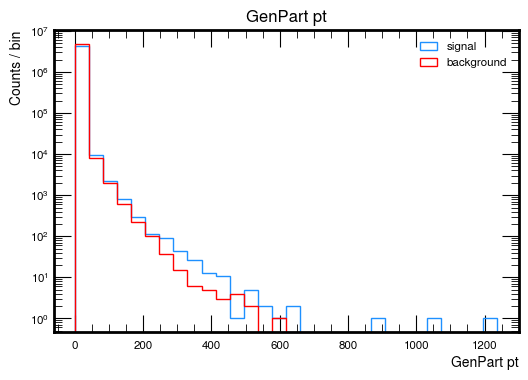

In [16]:
plt.figure(dpi=100)
ptMax=max(ak.max(GenParticlesSGN.GenPart_pt), ak.max(GenParticlesBKG.GenPart_pt))
plt.hist(ak.flatten(GenParticlesSGN.GenPart_pt), bins=30, label="signal", histtype='step', color='dodgerblue', range=(0,ptMax))
plt.hist(ak.flatten(GenParticlesBKG.GenPart_pt), bins=30, label="background", histtype='step', color='red', range=(0,ptMax))
plt.title("GenPart pt")
plt.xlabel("GenPart pt")
plt.ylabel('Counts / bin')
plt.yscale("log")
plt.legend()
plt.show()

## genJets constituents

In [17]:
def wrapInPhi(phi):
    """Map angle values to the range [-pi, pi]."""
    return (phi + np.pi) % (2 * np.pi) - np.pi

def fixWrap(particlesPhi, ref):
    particlesPhi = np.asarray(particlesPhi)
    ref = np.asarray(ref)
    # Create mask where the absolute difference is greater than pi
    mask = np.abs(particlesPhi - ref) > np.pi
    # Adjust the values
    adjust_pos = mask & (particlesPhi > ref)
    adjust_neg = mask & (particlesPhi < ref)

    particlesPhi[adjust_pos] -= 2 * np.pi
    particlesPhi[adjust_neg] += 2 * np.pi
    
    return particlesPhi

def compute_dR(eta1, phi1, eta2, phi2):
    dphi = phi1 - phi2
    deta = eta1 - eta2
    return np.sqrt(dphi**2 + deta**2)

def plot_particles_in_jets_withLHE(jets_pt, jets_eta, jets_phi, particles_eta, particles_phi, LHE_eta, LHE_phi, radius=0.4):
    """axs, """ 
    num_jets= len(jets_pt)
#     if num_jets == 1:
#         axs = [axs]
    
    fig, axs = plt.subplots(1, num_jets, figsize=(num_jets * 6, 6), dpi=300)
        
    for i in range(num_jets):
        jet_pt = jets_pt[i]
        jet_eta = jets_eta[i]
        jet_phi = wrapInPhi(jets_phi[i])
        
        # Assuming particles_eta and particles_phi are lists of lists, where each sublist contains particles for the corresponding jet
        jet_particles_eta = particles_eta[i]
        jet_particles_phi = fixWrap(particles_phi[i], jet_phi)

        # Plot jets with different markers and colors
        axs[i].scatter(jet_eta, jet_phi, color='red', marker='o', label=f'genJet ($p_T$ = {jet_pt:.2f} GeV)')

        # Plot particles with different markers and colors
        axs[i].scatter(jet_particles_eta, jet_particles_phi, color='blue', marker='x', label='genParticles')

        # Draw circle around jet
        circle = plt.Circle((jet_eta, jet_phi), radius, color='red', fill=False, linestyle='--', label="ak4")
        axs[i].add_patch(circle)
        
        # Compute dR for LHE particles
        LHE_phi = fixWrap(LHE_phi, jet_phi)
        dR = compute_dR(LHE_eta, LHE_phi, jet_eta, jet_phi)
        matched_LHE_indices = np.where(dR < radius)[0]
        matched_LHE_eta = LHE_eta[matched_LHE_indices]
        matched_LHE_phi = LHE_phi[matched_LHE_indices]
        
        # Plot LHE particles with different markers and colors
        axs[i].scatter(matched_LHE_eta, matched_LHE_phi, color='green', marker='s', label='LHEParticle')

        # Adding labels and legend
        axs[i].set_xlabel('$\eta$')
        axs[i].set_ylabel('$\phi$')
        axs[i].set_title(f'GEN and LHE Particles in genJet {i+1}')
        axs[i].legend()

        # Set the same scale for both axes for better visualization
        axs[i].axis('equal')

    plt.tight_layout()
#     plt.savefig("jetConstituents_"+str(jet_pt)+".png")
    plt.show()

## eta studies

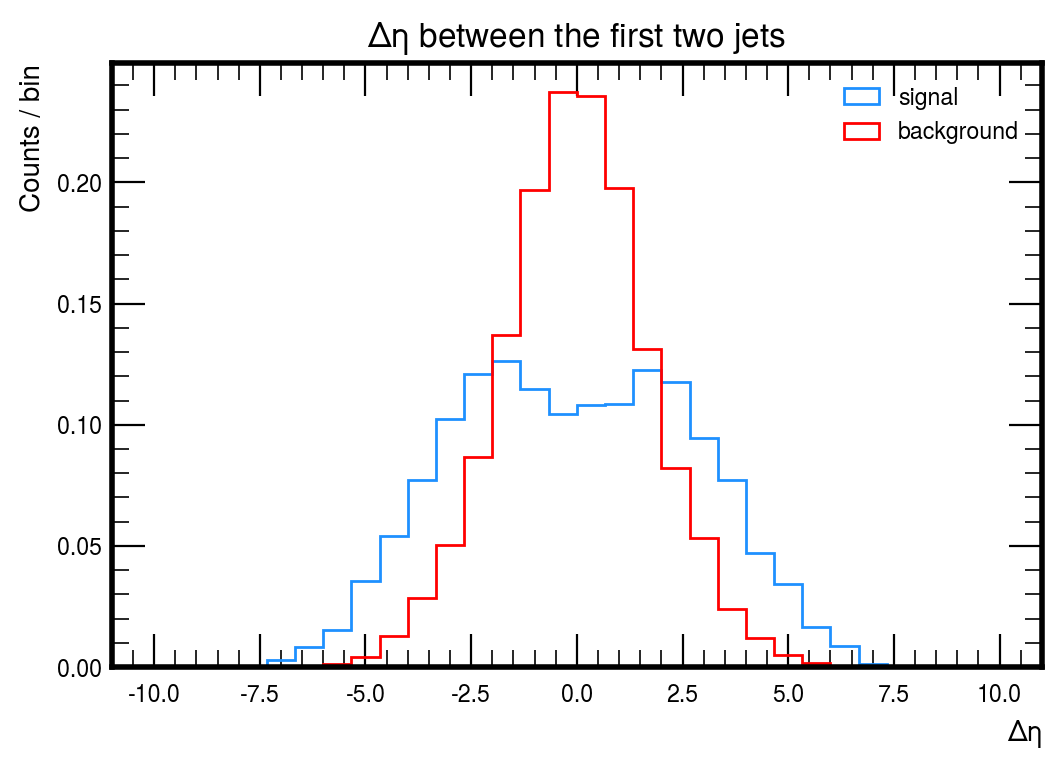

In [18]:
PT_CUT = 50

detaSGN = []
etaSGN = []
for jets_eta_ev, jets_pt_ev in zip(GenJetsSGN.GenJet_eta, GenJetsSGN.GenJet_pt):
    if jets_pt_ev[0] > PT_CUT and jets_pt_ev[1] > PT_CUT:
        detaSGN.append((jets_eta_ev[0] - jets_eta_ev[1]))
        etaSGN.append(jets_eta_ev[1])
        
detaBKG = []
etaBKG = []
for jets_eta_ev, jets_pt_ev in zip(GenJetsBKG.GenJet_eta, GenJetsBKG.GenJet_pt):
    if jets_pt_ev[0] > PT_CUT and jets_pt_ev[1] > PT_CUT:
        detaBKG.append((jets_eta_ev[0] - jets_eta_ev[1]))
        etaBKG.append(jets_eta_ev[1])

plt.figure(dpi=200)
plt.title(r"$\Delta\eta$ between the first two jets")
plt.xlabel(r"$\Delta\eta$")
plt.ylabel('Counts / bin')

etaMax = 10
plt.hist(detaSGN, bins=30, density=True, label="signal", histtype='step', color='dodgerblue', range=(-etaMax,etaMax))
plt.hist(detaBKG, bins=30, density=True, label="background", histtype='step', color='red', range=(-etaMax,etaMax))

plt.legend()
#plt.yscale("log")
plt.show()

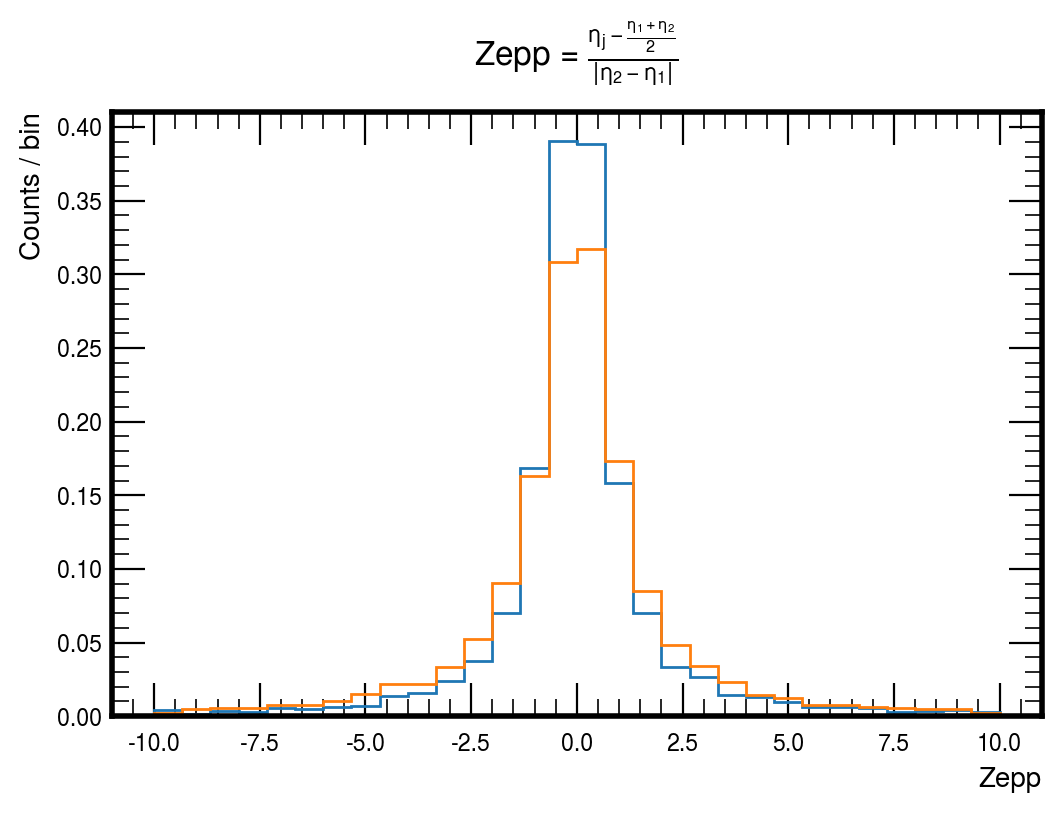

In [19]:
PT_CUT = 30
zeppSGN = []
for jets_eta_ev, jets_pt_ev in zip(GenJetsSGN.GenJet_eta, GenJetsSGN.GenJet_pt):
    if len(jets_eta_ev)>3 and jets_pt_ev[0] > PT_CUT and jets_pt_ev[1] > PT_CUT and jets_pt_ev[2] > PT_CUT:
        eta1 = jets_eta_ev[0]
        eta2 = jets_eta_ev[1]
        etaj = jets_eta_ev[2]
        zeppSGN.append((etaj - (eta1 + eta2)/2)/abs(eta2 - eta1))

zeppBKG = []
for jets_eta_ev, jets_pt_ev in zip(GenJetsBKG.GenJet_eta, GenJetsBKG.GenJet_pt):
    if len(jets_eta_ev)>3 and jets_pt_ev[0] > PT_CUT and jets_pt_ev[1] > PT_CUT and jets_pt_ev[2] > PT_CUT:
        eta1 = jets_eta_ev[0]
        eta2 = jets_eta_ev[1]
        etaj = jets_eta_ev[2]
        zeppBKG.append((etaj - (eta1 + eta2)/2)/abs(eta2 - eta1))

plt.figure(dpi=200)
plt.title(r"Zepp = $\frac{\eta_j - \frac{\eta_1 + \eta_2}{2}}{|\eta_2 - \eta_1|}$", y=1.05)
plt.xlabel("Zepp")
plt.ylabel('Counts / bin')

plt.hist(zeppSGN, histtype="step", bins=30, range=(-10,10), density=True)
plt.hist(zeppBKG, histtype="step", bins=30, range=(-10,10), density=True)

#plt.yscale("log")
plt.show()

## jets constituents 

In [20]:
def computeEtaPhiEnergyList(GenJets, GenParticles, PT_CUT = 50, NJETS = 2):
    genPar_eta_list = [[], []]  # 0 eta pos 1 eta neg
    genPar_phi_list = [[], []]
    genPar_energy_list = [[], []]

    for ev in range(len(GenJets.GenJet_pt)):
        genjets_pt = GenJets.GenJet_pt[ev]
        genJets_eta = GenJets.GenJet_eta[ev]
        genJets_phi = GenJets.GenJet_phi[ev]
        nConstituents = GenJets.GenJet_nConstituents[ev]
        constituents = GenJets.GenJet_constituents[ev]

        genParts_pt = GenParticles.GenPart_pt[ev]
        genParts_eta = GenParticles.GenPart_eta[ev]
        genParts_phi = GenParticles.GenPart_phi[ev]
        
        if len(genjets_pt) < NJETS or genjets_pt[0] < PT_CUT or genjets_pt[1] < PT_CUT : continue

        for i in range(NJETS):
            ind = 0 if genJets_eta[i] > 0 else 1
            genPartsInJetIndices = getJetConstituents(i, nConstituents, constituents)
            eta_diff = genParts_eta[genPartsInJetIndices] - genJets_eta[i]
            phi_diff = fixWrap(wrapInPhi(genParts_phi[genPartsInJetIndices]), genJets_phi[i]) - genJets_phi[i]
            energy = genParts_pt[genPartsInJetIndices] * np.cosh(genParts_eta[genPartsInJetIndices])

            genPar_eta_list[ind].extend(eta_diff)
            genPar_phi_list[ind].extend(phi_diff)
            genPar_energy_list[ind].extend(energy)
    
    return genPar_eta_list, genPar_phi_list, genPar_energy_list

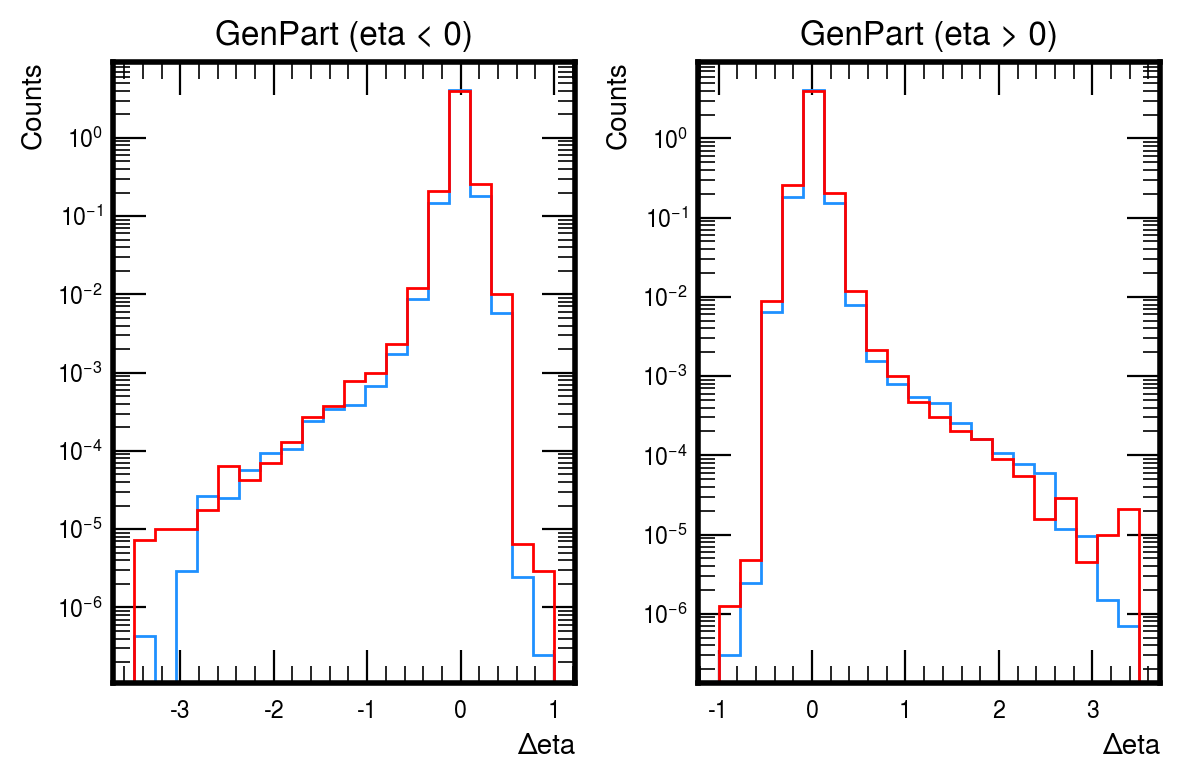

In [21]:
# Plotting the histograms
fig, axes = plt.subplots(1, 2, dpi=200)

sgn_eta_list, _, sgn_energy_list = computeEtaPhiEnergyList(GenJetsSGN, GenParticlesSGN)
bkg_eta_list, _, bkg_energy_list = computeEtaPhiEnergyList(GenJetsBKG, GenParticlesBKG)

# Plot for positive eta
axes[1].hist(
    sgn_eta_list[0],
    weights=sgn_energy_list[0], 
    bins=20,
    histtype='step',
    label = 'signal',
    color='dodgerblue',
    range=(-1, 3.5),
    density=True
)
axes[1].hist(
    bkg_eta_list[0],
    weights=bkg_energy_list[0], 
    bins=20,
    histtype='step',
    label = 'background',
    color='red',
    range=(-1, 3.5),
    density=True
)
axes[1].set_title('GenPart (eta > 0)')
axes[1].set_xlabel('Δeta')
axes[1].set_ylabel('Counts')
axes[1].set_yscale('log')

# Plot for negative eta
axes[0].hist(
    sgn_eta_list[1],
    weights=sgn_energy_list[1], 
    bins=20,
    histtype='step',
    label = 'signal',
    color='dodgerblue',
    range=(-3.5, 1),
    density=True
)
axes[0].hist(
    bkg_eta_list[1],
    weights=bkg_energy_list[1], 
    bins=20,
    histtype='step',
    label = 'background',
    color='red',
    range=(-3.5, 1),
    density=True
)
axes[0].set_title('GenPart (eta < 0)')
axes[0].set_xlabel('Δeta')
axes[0].set_ylabel('Counts')
axes[0].set_yscale('log')

plt.tight_layout()
plt.show()